In [1]:
# Constants
import config.execution_parameters as consts

# Project libraries
import src.simulator_package.simulator_functions
from src.simulator_package.simulator_functions import *
import src.hmm_package.generate_hmm
from src.hmm_package.generate_hmm import *
import src.plot_and_print_info.plots_and_print_info
from src.plot_and_print_info.plots_and_print_info import *

import random
import importlib

In [2]:
importlib.reload(src.hmm_package.generate_hmm)
importlib.reload(src.simulator_package.simulator_functions)
importlib.reload(consts)
importlib.reload(src.plot_and_print_info.plots_and_print_info)
from src.hmm_package.generate_hmm import *
from src.simulator_package.simulator_functions import *
from config.execution_parameters import *
from src.plot_and_print_info.plots_and_print_info import *

In [3]:
# Store constants
cm = {}
for k, v in consts.__dict__.items():
    if not k.startswith('__'):
        cm[k] = v

## Generate the simulation

In [4]:
# Generate the simulation instantiating the SimulationClass and calling its method 'simulate'
advertising_campaign = SimulationClass(cm, ANALYSIS_MODE)
advertising_campaign.simulate(cm)

adstock = compute_adstock(cm, observation=advertising_campaign.results["user_expositions"])
output = np.append( np.zeros([adstock.shape[0], 1]), advertising_campaign.results["user_outcome"], axis=1 )

2022-06-18 10:02:00.759177: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
count_conversions(output)

Percentage of conversion is: 0.5231533558305211%.


0.5231533558305211

In [6]:
clicks = [sum(el for el in output[:,day] if el==1.0) for day in range(time+1)]

In [7]:
output

array([[0., 0., 0., ..., 2., 2., 2.],
       [0., 0., 0., ..., 2., 2., 2.],
       [0., 0., 0., ..., 2., 2., 2.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

NameError: name 'N_users' is not defined

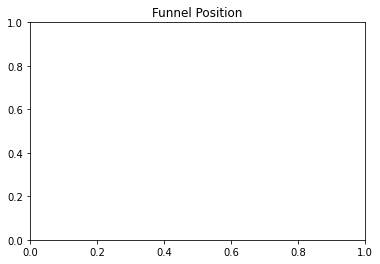

In [8]:
plot_all_funnel_positions(cm, advertising_campaign, 5)

In [15]:
[1:10]

SyntaxError: invalid syntax (1517189022.py, line 1)

## Generate some empty users to facilitate the fitting

In [ ]:
# We want to fit the model over a pool of empty users, with a certain conversion rate to mimic external factors
empty_users = 5000
adstock_only_empty = tf.zeros([empty_users, N_states, execution_duration+1], dtype=float)
output_only_empty = np.zeros([empty_users, execution_duration+1])

# Lets add a 3% of conversion due to external factors
for temp in range(round(0.03*empty_users)):
    output_only_empty[temp, random.randint(1,execution_duration+1):] = 1

In [ ]:
adstock_with_empty = tf.concat([adstock,adstock_only_empty], axis=0)
output_with_empty = tf.concat([output,output_only_empty], axis=0)

In [21]:
MU = [ -2.7419195, -1.1010361, -5.92728  ]
inverse_sigmoid = lambda x: np.log(x/(1-x))
# Now try to fit the model sampled from the real parameters.
initializer={
    'BETA': tf.keras.initializers.Constant([ 0.6, -0.3, 0.2, 0.4, -0.3, 0.7, 0.2, -0.3, 1.]),
    'INIT_PROB': tf.keras.initializers.Constant(inverse_sigmoid(0.9)), #
    'CLICK_PROB': tf.keras.initializers.Constant(inverse_sigmoid(0.85))},
model = build_hmm_to_fit_beta(cm, mu=MU, initializer=initializer )

compiler = CompilerInfoBeta(cm, False)
model.compile(
    loss = compiler.loss,
    optimizer = compiler.optimizer,
    run_eagerly = True
)
BETA = [0.7, -0.3, 0.15, 0.4, -0.4, 0.8]
history = fit_model(cm, model, adstock, output)
#save_result(model, adstock, output, initializer)
#

Mu: [-2.0, -1.0, -4.0] Beta: [0.6, -0.3, 0.2, 0.4, -0.3, 0.7, 0.2, -0.3, 1.0] Init Prob: [<tf.Tensor: shape=(), dtype=float32, numpy=0.90000004>] Click Prob: [<tf.Tensor: shape=(), dtype=float32, numpy=0.85>]
Epoch 1/100
11/11 [==============================] - 4s 373ms/step - loss: 9087.0430
Mu: [-2.0108945, -0.98911065, -3.9891124] Beta: [0.5891084, -0.28911525, 0.21085955, 0.4, -0.3, 0.7, 0.18910837, -0.2891236, 1.0100821] Init Prob: [<tf.Tensor: shape=(), dtype=float32, numpy=0.9009767>] Click Prob: [<tf.Tensor: shape=(), dtype=float32, numpy=0.8486059>]
Epoch 2/100
11/11 [==============================] - 4s 371ms/step - loss: 8861.2100
Mu: [-2.0213335, -0.97867143, -3.978694] Beta: [0.57868326, -0.2786828, 0.22115931, 0.4, -0.3, 0.7, 0.17868753, -0.2786969, 1.0191731] Init Prob: [<tf.Tensor: shape=(), dtype=float32, numpy=0.901908>] Click Prob: [<tf.Tensor: shape=(), dtype=float32, numpy=0.8472588>]
Epoch 3/100
11/11 [==============================] - 4s 369ms/step - loss: 8644.8

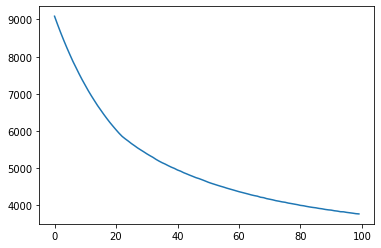

In [22]:
plt.plot(model.history.epoch, model.history.history['loss'])

In [24]:
fit_model(cm, model, adstock, output)

Mu: [-2.6819289, -0.32243776, -3.130069] Beta: [0.017221672, -0.024005938, 0.5423065, 0.4, -0.3, 0.7, -0.0, 0.0, 0.6091145] Init Prob: [<tf.Tensor: shape=(), dtype=float32, numpy=0.9547188>] Click Prob: [<tf.Tensor: shape=(), dtype=float32, numpy=0.6971052>]
Epoch 1/100
11/11 [==============================] - 4s 384ms/step - loss: 3757.1560
Mu: [-2.6867461, -0.31910777, -3.1221652] Beta: [0.014267718, -0.026792388, 0.54013926, 0.4, -0.3, 0.7, -0.0, 0.0, 0.604837] Init Prob: [<tf.Tensor: shape=(), dtype=float32, numpy=0.9550173>] Click Prob: [<tf.Tensor: shape=(), dtype=float32, numpy=0.69533205>]
Epoch 2/100
11/11 [==============================] - 4s 371ms/step - loss: 3747.1226
Mu: [-2.6915205, -0.31585988, -3.1139874] Beta: [0.011379179, -0.029706761, 0.5380958, 0.4, -0.3, 0.7, -0.0, 0.0, 0.6009716] Init Prob: [<tf.Tensor: shape=(), dtype=float32, numpy=0.95531297>] Click Prob: [<tf.Tensor: shape=(), dtype=float32, numpy=0.69356203>]
Epoch 3/100
11/11 [=============================


KeyboardInterrupt



AttributeError: 'dict' object has no attribute 'N_users'